### Проект N_3
# Анализ поведения пользователей


### Цель исследования:
### Проследить влияние онбординга на поведение пользователей игры Quiz Freeze. 

- Определить, отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение.
- Выяснить, существует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь?
- Выявить, как часто пользователи начинают обучение после того, как выбрали уровень сложности тренировок?

Задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Проверить, насколько прозрачен процесс взаимодействия с игрой.

Проект выполняется на основе данных о пользователях игры, зарегистрировавшихся в течение 2018 года

                                                                                                                 Соколова Юлия SDA-1027

### 0. Чтение и подготовка данных

In [1]:
import pandas as pd
events_df=pd.read_csv('data/7_4_Events.csv')
#Переводим дату в формат to_datetime, данные с ошибкой изменяются на NaN:
events_df['start_time']=pd.to_datetime(events_df['start_time'],errors='coerce',dayfirst=False) 

In [2]:
#Отфильтровываем строки с событием "регистрация" в 2018 году:
mask1=(events_df['start_time']>='2018-01-01')&(events_df['start_time']<'2019-01-01')&(events_df['event_type']=='registration')

#Из предыдущего датафрейма извлекаем в отдельный список user_id:
user_list=list(events_df[mask1]['user_id'])

#Отфильтровываем основной датафрейм таким образом, чтобы в нем оказались только юзеры из созданного выше списка, то есть зарегистрированные в 2018 году:
events_df=events_df[events_df['user_id'].isin(user_list)]
events_df

,id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836
...,...,...,...,...,...,...
118359,147262,tutorial_start,NaN,2019-01-01 03:26:18,49554.0,47756
118360,147263,tutorial_finish,NaN,2019-01-01 03:29:25,49554.0,47756
118362,147265,level_choice,easy,2019-01-01 05:04:52,NaN,47755
118363,147266,level_choice,medium,2019-01-01 05:42:11,NaN,47756


In [3]:
purchase_df=pd.read_csv('data/7_4_Purchase.csv')
purchase_df['event_datetime']=pd.to_datetime(purchase_df['event_datetime'],dayfirst=False)

#Таким же образом отфильтровываем основной датафрейм с покупками, чтобы в нем оказались только юзеры, зарегистрированные в 2018 году
purchase_df=purchase_df[purchase_df['user_id'].isin(user_list)] 
purchase_df

,id,user_id,event_datetime,amount
1171,16845,27845,2018-01-03 18:53:43,100
1172,16846,27865,2018-01-04 14:46:10,250
1174,16848,27911,2018-01-07 08:19:12,50
1175,16849,27910,2018-01-07 12:11:34,100
1176,16850,27940,2018-01-07 13:16:41,200
...,...,...,...,...
2767,18441,47498,2019-01-02 03:48:19,100
2768,18442,47647,2019-01-02 23:26:26,150
2769,18443,47554,2019-01-03 00:36:36,50
2774,18448,47742,2019-01-04 12:51:41,50


### 1. Определить, насколько обучение сокращает время прохождения этапов игры.

In [4]:
#Создаем новый признак с датафрейме с покупками - "тип события" и значение для него "покупка":
purchase_df['event_type'] = 'purchase'
#Переименовываем столбцы в датафреймах, чтобы объединить их
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})
#Объединяем два датафрейма в один
total_events_df = pd.concat([events_df,purchase_df],sort=False)
#Обновляем индексы и сортируем данные по времени регистрации события
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')
total_events_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [5]:
#Создаем список пользователей, начинавших обучение хотябы раз
mask2=total_events_df['event_type'] == 'tutorial_start'
started_tutorial_users=list(total_events_df[mask2]['user_id'])

#Создаем список пользователей, завершивших обучение хотябы раз
mask3=total_events_df['event_type'] == 'tutorial_finish'
finished_tutorial_users=list(total_events_df[mask3]['user_id'])

#Создаем датафрейм для пользователей, начавших обучение хотябы раз
started_df=total_events_df[total_events_df['user_id'].isin(started_tutorial_users)]
started_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [6]:
#Создаем датафрейм для пользователей, закончивших обучение хотябы раз
finished_df=total_events_df[total_events_df['user_id'].isin(finished_tutorial_users)]
finished_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [7]:
#Создаем датафрейм для пользователей, ни разу не начинавших обучение
no_tutorial_df=total_events_df[~total_events_df['user_id'].isin(started_tutorial_users)]
no_tutorial_df['user_id'].nunique()

8068

In [8]:
print('Общее количество пользователей:', total_events_df['user_id'].nunique(), '\n'
    'Количество пользователей, хотябы раз начавших обучение:', started_df['user_id'].nunique(), '\n'
      'Количество пользователей, хотябы раз завершивших обучение:', finished_df['user_id'].nunique(), '\n'
      'Количество пользователей, ни разу не начинавших обучение:', no_tutorial_df['user_id'].nunique())

Общее количество пользователей: 19926 
Количество пользователей, хотябы раз начавших обучение: 11858 
Количество пользователей, хотябы раз завершивших обучение: 10250 
Количество пользователей, ни разу не начинавших обучение: 8068


#### a) Пользователи, начавшие обучение хотябы раз

In [9]:
#Для каждой группы создаем датафреймы отдельно для каждого события, чтобы объединить их и вычислить среднее время между событиями
#Регистрации пользователей, хотябы раз начавших обучение
registration_df = started_df[started_df['event_type']=='registration']
#Переименовываем столбец start_time в registration_time для дальнейшего объединения
registration_df = registration_df.rename(columns={'start_time':'registration_time'})
registration_df

,event_id,event_type,selected_level,registration_time,tutorial_id,user_id,purchase_id,amount
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
14,80322.0,registration,NaN,2018-01-01 18:24:01,NaN,27839,NaN,NaN
...,...,...,...,...,...,...,...,...
66919,147227.0,registration,NaN,2018-12-31 03:29:04,NaN,47748,NaN,NaN
66939,147247.0,registration,NaN,2018-12-31 13:55:01,NaN,47751,NaN,NaN
66941,147249.0,registration,NaN,2018-12-31 18:58:55,NaN,47753,NaN,NaN
66947,147255.0,registration,NaN,2018-12-31 21:15:14,NaN,47755,NaN,NaN


In [10]:
#Начало обучения
tutorial_df = started_df[started_df['event_type']=='tutorial_start']
tutorial_df = tutorial_df.rename(columns={'start_time':'tutorial_start_time'})
tutorial_df 

,event_id,event_type,selected_level,tutorial_start_time,tutorial_id,user_id,purchase_id,amount
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
8,80316.0,tutorial_start,NaN,2018-01-01 15:00:51,31506.0,27835,NaN,NaN
10,80318.0,tutorial_start,NaN,2018-01-01 15:40:43,31507.0,27836,NaN,NaN
12,80320.0,tutorial_start,NaN,2018-01-01 17:47:40,31508.0,27833,NaN,NaN
15,80323.0,tutorial_start,NaN,2018-01-01 19:11:36,31509.0,27839,NaN,NaN
...,...,...,...,...,...,...,...,...
66934,147242.0,tutorial_start,NaN,2018-12-31 10:21:11,49550.0,47747,NaN,NaN
66943,147251.0,tutorial_start,NaN,2018-12-31 19:38:14,49551.0,47751,NaN,NaN
66945,147253.0,tutorial_start,NaN,2018-12-31 20:54:56,49552.0,47753,NaN,NaN
66952,147260.0,tutorial_start,NaN,2019-01-01 00:08:14,49553.0,47755,NaN,NaN


In [11]:
#Конец обучения
finish_tutorial_df = started_df[started_df['event_type']=='tutorial_finish']
finish_tutorial_df = finish_tutorial_df.rename(columns={'start_time':'finish_time'})
finish_tutorial_df

,event_id,event_type,selected_level,finish_time,tutorial_id,user_id,purchase_id,amount
9,80317.0,tutorial_finish,NaN,2018-01-01 15:06:15,31506.0,27835,NaN,NaN
11,80319.0,tutorial_finish,NaN,2018-01-01 15:42:58,31507.0,27836,NaN,NaN
13,80321.0,tutorial_finish,NaN,2018-01-01 17:50:08,31508.0,27833,NaN,NaN
16,80324.0,tutorial_finish,NaN,2018-01-01 19:16:32,31509.0,27839,NaN,NaN
18,80326.0,tutorial_finish,NaN,2018-01-01 19:48:01,31510.0,27834,NaN,NaN
...,...,...,...,...,...,...,...,...
66935,147243.0,tutorial_finish,NaN,2018-12-31 10:22:45,49550.0,47747,NaN,NaN
66944,147252.0,tutorial_finish,NaN,2018-12-31 19:39:34,49551.0,47751,NaN,NaN
66946,147254.0,tutorial_finish,NaN,2018-12-31 20:57:07,49552.0,47753,NaN,NaN
66953,147261.0,tutorial_finish,NaN,2019-01-01 00:09:30,49553.0,47755,NaN,NaN


In [12]:
#Выбор уровня сложности
level_df = started_df[started_df['event_type']=='level_choice']
level_df = level_df.rename(columns={'start_time':'level_time'})
level_df

,event_id,event_type,selected_level,level_time,tutorial_id,user_id,purchase_id,amount
19,80327.0,level_choice,medium,2018-01-01 20:37:22,NaN,27835,NaN,NaN
23,80331.0,level_choice,hard,2018-01-01 22:37:50,NaN,27839,NaN,NaN
36,80344.0,level_choice,medium,2018-01-02 05:18:42,NaN,27840,NaN,NaN
38,80346.0,level_choice,hard,2018-01-02 06:19:18,NaN,27845,NaN,NaN
45,80353.0,level_choice,easy,2018-01-02 08:46:03,NaN,27842,NaN,NaN
...,...,...,...,...,...,...,...,...
66932,147240.0,level_choice,medium,2018-12-31 09:59:00,NaN,47732,NaN,NaN
66937,147245.0,level_choice,medium,2018-12-31 12:24:40,NaN,47747,NaN,NaN
66948,147256.0,level_choice,medium,2018-12-31 22:36:19,NaN,47753,NaN,NaN
66956,147265.0,level_choice,easy,2019-01-01 05:04:52,NaN,47755,NaN,NaN


In [13]:
#Выбор пакетов вопросов
pack_df = started_df[started_df['event_type']=='pack_choice']
pack_df = pack_df.rename(columns={'start_time':'pack_time'})
pack_df

,event_id,event_type,selected_level,pack_time,tutorial_id,user_id,purchase_id,amount
20,80328.0,pack_choice,NaN,2018-01-01 20:38:43,NaN,27835,NaN,NaN
24,80332.0,pack_choice,NaN,2018-01-01 22:42:54,NaN,27839,NaN,NaN
39,80347.0,pack_choice,NaN,2018-01-02 06:25:12,NaN,27845,NaN,NaN
53,80361.0,pack_choice,NaN,2018-01-02 11:59:26,NaN,27849,NaN,NaN
58,80366.0,pack_choice,NaN,2018-01-02 14:14:51,NaN,27843,NaN,NaN
...,...,...,...,...,...,...,...,...
66923,147231.0,pack_choice,NaN,2018-12-31 05:06:10,NaN,47742,NaN,NaN
66931,147239.0,pack_choice,NaN,2018-12-31 07:59:18,NaN,47744,NaN,NaN
66933,147241.0,pack_choice,NaN,2018-12-31 10:05:18,NaN,47732,NaN,NaN
66949,147257.0,pack_choice,NaN,2018-12-31 22:38:05,NaN,47753,NaN,NaN


In [14]:
#Покупка платных пакетов вопросов
purchase_df = started_df[started_df['event_type']=='purchase']
purchase_df = purchase_df.rename(columns={'start_time':'purchase_time'})
purchase_df

,event_id,event_type,selected_level,purchase_time,tutorial_id,user_id,purchase_id,amount
66959,NaN,purchase,NaN,2018-01-03 18:53:43,NaN,27845,16845.0,100.0
66960,NaN,purchase,NaN,2018-01-04 14:46:10,NaN,27865,16846.0,250.0
66961,NaN,purchase,NaN,2018-01-07 08:19:12,NaN,27911,16848.0,50.0
66962,NaN,purchase,NaN,2018-01-07 12:11:34,NaN,27910,16849.0,100.0
66963,NaN,purchase,NaN,2018-01-07 13:16:41,NaN,27940,16850.0,200.0
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [15]:
#Объединяем датасеты в один
#Создаем датасет, добавляя в него события по одному и удаляя лишние столбцы
#Присоединяем к регистрациям выбор уровня по правому датафрейму, так как не имеет смысл рассматривать юзеров, которые не перешли к выбору уровня
event_times_df = registration_df.merge(level_df,on='user_id',how='right')
event_times_df = event_times_df.drop(
    columns=['event_id_x','selected_level_x','tutorial_id_x','purchase_id_x','amount_x','event_id_y','tutorial_id_y','purchase_id_y','amount_y']
    )
event_times_df

,event_type_x,registration_time,user_id,event_type_y,selected_level_y,level_time
0,registration,2018-01-01 11:54:47,27835,level_choice,medium,2018-01-01 20:37:22
1,registration,2018-01-01 18:24:01,27839,level_choice,hard,2018-01-01 22:37:50
2,registration,2018-01-01 20:53:21,27840,level_choice,medium,2018-01-02 05:18:42
3,registration,2018-01-02 01:35:56,27845,level_choice,hard,2018-01-02 06:19:18
4,registration,2018-01-01 23:18:46,27842,level_choice,easy,2018-01-02 08:46:03
...,...,...,...,...,...,...
8239,registration,2018-12-30 14:20:21,47732,level_choice,medium,2018-12-31 09:59:00
8240,registration,2018-12-31 03:01:17,47747,level_choice,medium,2018-12-31 12:24:40
8241,registration,2018-12-31 18:58:55,47753,level_choice,medium,2018-12-31 22:36:19
8242,registration,2018-12-31 21:15:14,47755,level_choice,easy,2019-01-01 05:04:52


In [16]:
#Далее добавляем датасеты левым объединением
event_times_df = event_times_df.merge(pack_df,on='user_id',how='left',suffixes=('_z', '_i'))
event_times_df = event_times_df.drop(
    columns=['selected_level','purchase_id','event_id','tutorial_id','amount']
    )
event_times_df

,event_type_x,registration_time,user_id,event_type_y,selected_level_y,level_time,event_type,pack_time
0,registration,2018-01-01 11:54:47,27835,level_choice,medium,2018-01-01 20:37:22,pack_choice,2018-01-01 20:38:43
1,registration,2018-01-01 18:24:01,27839,level_choice,hard,2018-01-01 22:37:50,pack_choice,2018-01-01 22:42:54
2,registration,2018-01-01 20:53:21,27840,level_choice,medium,2018-01-02 05:18:42,NaN,NaT
3,registration,2018-01-02 01:35:56,27845,level_choice,hard,2018-01-02 06:19:18,pack_choice,2018-01-02 06:25:12
4,registration,2018-01-01 23:18:46,27842,level_choice,easy,2018-01-02 08:46:03,NaN,NaT
...,...,...,...,...,...,...,...,...
8239,registration,2018-12-30 14:20:21,47732,level_choice,medium,2018-12-31 09:59:00,pack_choice,2018-12-31 10:05:18
8240,registration,2018-12-31 03:01:17,47747,level_choice,medium,2018-12-31 12:24:40,NaN,NaT
8241,registration,2018-12-31 18:58:55,47753,level_choice,medium,2018-12-31 22:36:19,pack_choice,2018-12-31 22:38:05
8242,registration,2018-12-31 21:15:14,47755,level_choice,easy,2019-01-01 05:04:52,NaN,NaT


In [17]:
event_times_df = event_times_df.merge(purchase_df,on='user_id',how='left',suffixes=('_3', '_4'))
event_times_df = event_times_df.drop(
    columns=['event_id','selected_level','tutorial_id','purchase_id']
    )
#Проверяем корректность данных: кол-во ненулевых значений в столбцах с событиями соотвествует кол-ву записей в соответствующем событийном датафрейме
event_times_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8244 entries, 0 to 8243
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   event_type_x       8244 non-null   object        
 1   registration_time  8244 non-null   datetime64[ns]
 2   user_id            8244 non-null   int64         
 3   event_type_y       8244 non-null   object        
 4   selected_level_y   8244 non-null   object        
 5   level_time         8244 non-null   datetime64[ns]
 6   event_type_3       5663 non-null   object        
 7   pack_time          5663 non-null   datetime64[ns]
 8   event_type_4       1578 non-null   object        
 9   purchase_time      1578 non-null   datetime64[ns]
 10  amount             1578 non-null   float64       
dtypes: datetime64[ns](4), float64(1), int64(1), object(5)
memory usage: 708.6+ KB


In [18]:
#Высчитываем промежутки времени между событиями
event_times_df['delta_registration_level']=event_times_df['level_time']-event_times_df['registration_time']
event_times_df['delta_level_pack']=event_times_df['pack_time']-event_times_df['level_time']
event_times_df['delta_pack_purchase']=event_times_df['purchase_time']-event_times_df['pack_time']
event_times_df['delta_registration_purchase']=event_times_df['purchase_time']-event_times_df['registration_time']
event_times_df.describe()

,registration_time,user_id,level_time,pack_time,purchase_time,amount,delta_registration_level,delta_level_pack,delta_pack_purchase,delta_registration_purchase
count,8244,8244.000000,8244,5663,1578,1578.000000,8244,5663,1578,1578
mean,2018-07-04 01:29:06.233988096,37832.572659,2018-07-04 08:40:47.261280768,2018-07-04 23:10:20.535581696,2018-07-06 08:38:25.337769472,110.487959,0 days 07:11:41.027292576,0 days 00:05:17.040967684,3 days 17:37:39.078580481,4 days 00:55:11.653992395
min,2018-01-01 11:54:47,27835.000000,2018-01-01 20:37:22,2018-01-01 20:38:43,2018-01-03 18:53:43,25.000000,0 days 00:08:15,0 days 00:00:19,0 days 00:44:50,0 days 04:36:58
25%,2018-03-24 15:52:06.750000128,32879.500000,2018-03-24 23:26:06.500000,2018-03-25 14:55:49,2018-03-27 17:36:18.750000128,50.000000,0 days 03:54:28.750000,0 days 00:03:05,1 days 21:21:47.750000,2 days 04:24:46.750000
50%,2018-06-23 20:01:43.500000,37755.000000,2018-06-24 02:51:24.500000,2018-06-26 20:53:44,2018-06-26 04:43:38.500000,100.000000,0 days 06:04:06.500000,0 days 00:04:57,3 days 12:45:06,3 days 19:36:08.500000
75%,2018-10-14 14:36:15,42873.250000,2018-10-14 22:45:34.500000,2018-10-15 18:55:23,2018-10-21 03:44:59,150.000000,0 days 09:36:09,0 days 00:07:07,5 days 09:38:37.750000,5 days 16:41:40.500000
max,2018-12-31 23:17:30,47756.000000,2019-01-01 05:42:11,2019-01-01 05:50:36,2019-01-06 07:14:25,300.000000,1 days 18:48:25,0 days 00:15:48,10 days 18:33:59,11 days 00:35:04
std,NaN,5773.035513,NaN,NaN,NaN,54.419018,0 days 04:34:08.503616882,0 days 00:02:43.700703288,2 days 04:37:04.160337559,2 days 04:50:06.596995302


#### b) Пользователи, закончившие обучение хотябы раз

In [19]:
#Регистрации пользователей, хотябы раз завершивших обучение
registration_df2 = finished_df[finished_df['event_type']=='registration']
#Переименовываем столбец start_time в registration_time для дальнейшего объединения
registration_df2 = registration_df2.rename(columns={'start_time':'registration_time'})

#Начало обучения
tutorial_df2 = finished_df[finished_df['event_type']=='tutorial_start']
tutorial_df2 = tutorial_df2.rename(columns={'start_time':'tutorial_start_time'})

#Конец обучения
finish_tutorial_df2 = finished_df[finished_df['event_type']=='tutorial_finish']
finish_tutorial_df2 = finish_tutorial_df2.rename(columns={'start_time':'finish_time'})

#Выбор уровня сложности
level_df2 = finished_df[finished_df['event_type']=='level_choice']
level_df2 = level_df2.rename(columns={'start_time':'level_time'})

#Выбор пакетов вопросов
pack_df2 = finished_df[finished_df['event_type']=='pack_choice']
pack_df2 = pack_df2.rename(columns={'start_time':'pack_time'})

#Покупка платных пакетов вопросов
purchase_df2 = finished_df[finished_df['event_type']=='purchase']
purchase_df2 = purchase_df2.rename(columns={'start_time':'purchase_time'})

event_times_df2 = registration_df2.merge(level_df2,on='user_id',how='right')
event_times_df2 = event_times_df2.drop(
    columns=['event_id_x','selected_level_x','tutorial_id_x','purchase_id_x','amount_x','event_id_y','tutorial_id_y','purchase_id_y','amount_y']
    )

event_times_df2 = event_times_df2.merge(pack_df2,on='user_id',how='left',suffixes=('_z', '_i'))
event_times_df2 = event_times_df2.drop(
    columns=['selected_level','purchase_id','event_id','tutorial_id','amount']
    )

event_times_df2 = event_times_df2.merge(purchase_df2,on='user_id',how='left',suffixes=('_3', '_4'))
event_times_df2 = event_times_df2.drop(
    columns=['event_id','selected_level','tutorial_id','purchase_id']
    )
#Проверяем корректность данных
event_times_df2.info()

#Высчитываем промежутки времени между событиями
event_times_df2['delta_registration_level']=event_times_df2['level_time']-event_times_df2['registration_time']
event_times_df2['delta_level_pack']=event_times_df2['pack_time']-event_times_df2['level_time']
event_times_df2['delta_pack_purchase']=event_times_df2['purchase_time']-event_times_df2['pack_time']
event_times_df2['delta_registration_purchase']=event_times_df2['purchase_time']-event_times_df2['registration_time']
event_times_df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   event_type_x       7501 non-null   object        
 1   registration_time  7501 non-null   datetime64[ns]
 2   user_id            7501 non-null   int64         
 3   event_type_y       7501 non-null   object        
 4   selected_level_y   7501 non-null   object        
 5   level_time         7501 non-null   datetime64[ns]
 6   event_type_3       5176 non-null   object        
 7   pack_time          5176 non-null   datetime64[ns]
 8   event_type_4       1447 non-null   object        
 9   purchase_time      1447 non-null   datetime64[ns]
 10  amount             1447 non-null   float64       
dtypes: datetime64[ns](4), float64(1), int64(1), object(5)
memory usage: 644.7+ KB


,registration_time,user_id,level_time,pack_time,purchase_time,amount,delta_registration_level,delta_level_pack,delta_pack_purchase,delta_registration_purchase
count,7501,7501.000000,7501,5176,1447,1447.000000,7501,5176,1447,1447
mean,2018-07-03 20:56:47.816424448,37822.983202,2018-07-04 04:02:24.671243776,2018-07-04 18:49:00.088098816,2018-07-05 19:13:35.193503744,110.988252,0 days 07:05:36.854819357,0 days 00:05:18.146058732,3 days 17:17:59.641326883,4 days 00:30:03.247408431
min,2018-01-01 11:54:47,27835.000000,2018-01-01 20:37:22,2018-01-01 20:38:43,2018-01-03 18:53:43,25.000000,0 days 00:08:15,0 days 00:00:19,0 days 00:44:50,0 days 04:36:58
25%,2018-03-24 08:41:42,32850.000000,2018-03-24 13:47:36,2018-03-25 02:24:08.500000,2018-03-27 14:29:37,50.000000,0 days 03:51:41,0 days 00:03:05,1 days 21:16:05.500000,2 days 04:09:55
50%,2018-06-23 15:04:17,37707.000000,2018-06-23 20:18:59,2018-06-25 20:19:02.500000,2018-06-25 22:56:25,100.000000,0 days 06:00:07,0 days 00:04:58,3 days 12:15:56,3 days 19:04:59
75%,2018-10-13 20:22:32,42850.000000,2018-10-14 04:29:37,2018-10-15 17:27:23,2018-10-19 18:35:42.500000,150.000000,0 days 09:25:42,0 days 00:07:11,5 days 08:53:44.500000,5 days 15:46:14
max,2018-12-31 23:17:30,47756.000000,2019-01-01 05:42:11,2019-01-01 05:50:36,2019-01-06 07:14:25,300.000000,1 days 18:48:25,0 days 00:15:48,10 days 18:33:59,11 days 00:35:04
std,NaN,5773.271851,NaN,NaN,NaN,54.565344,0 days 04:30:23.231509186,0 days 00:02:44.449118501,2 days 04:31:59.804658578,2 days 04:47:29.946150698


#### c) Пользователи, ни разу не начинавшие обучение

In [20]:
#Регистрации пользователей, ни разу не начинавших обучение
registration_df3 = no_tutorial_df[no_tutorial_df['event_type']=='registration']
#Переименовываем столбец start_time в registration_time для дальнейшего объединения
registration_df3 = registration_df3.rename(columns={'start_time':'registration_time'})
registration_df3

,event_id,event_type,selected_level,registration_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
5,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaN
6,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaN
27,80335.0,registration,NaN,2018-01-02 00:13:22,NaN,27844,NaN,NaN
37,80345.0,registration,NaN,2018-01-02 06:05:02,NaN,27848,NaN,NaN
...,...,...,...,...,...,...,...,...
66936,147244.0,registration,NaN,2018-12-31 12:03:59,NaN,47749,NaN,NaN
66938,147246.0,registration,NaN,2018-12-31 13:42:40,NaN,47750,NaN,NaN
66940,147248.0,registration,NaN,2018-12-31 18:49:30,NaN,47752,NaN,NaN
66942,147250.0,registration,NaN,2018-12-31 19:14:08,NaN,47754,NaN,NaN


In [21]:
#Выбор уровня сложности
level_df3 = no_tutorial_df[no_tutorial_df['event_type']=='level_choice']
level_df3 = level_df3.rename(columns={'start_time':'level_time'})

#Выбор пакетов вопросов
pack_df3 = no_tutorial_df[no_tutorial_df['event_type']=='pack_choice']
pack_df3 = pack_df3.rename(columns={'start_time':'pack_time'})

#Покупка платных пакетов вопросов
purchase_df3 = no_tutorial_df[no_tutorial_df['event_type']=='purchase']
purchase_df3 = purchase_df3.rename(columns={'start_time':'purchase_time'})

In [22]:
event_times_df3 = registration_df3.merge(level_df3,on='user_id',how='left')
event_times_df3 = event_times_df3.drop(
    columns=['event_id_x','selected_level_x','tutorial_id_x','purchase_id_x','amount_x','event_id_y','tutorial_id_y','purchase_id_y','amount_y']
    )
event_times_df3

,event_type_x,registration_time,user_id,event_type_y,selected_level_y,level_time
0,registration,2018-01-01 03:48:40,27832,NaN,NaN,NaT
1,registration,2018-01-01 14:08:40,27837,NaN,NaN,NaT
2,registration,2018-01-01 14:42:58,27838,NaN,NaN,NaT
3,registration,2018-01-02 00:13:22,27844,NaN,NaN,NaT
4,registration,2018-01-02 06:05:02,27848,NaN,NaN,NaT
...,...,...,...,...,...,...
8063,registration,2018-12-31 12:03:59,47749,NaN,NaN,NaT
8064,registration,2018-12-31 13:42:40,47750,NaN,NaN,NaT
8065,registration,2018-12-31 18:49:30,47752,NaN,NaN,NaT
8066,registration,2018-12-31 19:14:08,47754,NaN,NaN,NaT


In [23]:
event_times_df3 = event_times_df3.merge(pack_df3,on='user_id',how='left',suffixes=('_z', '_i'))
event_times_df3 = event_times_df3.drop(
    columns=['selected_level','purchase_id','event_id','tutorial_id','amount']
    )

event_times_df3 = event_times_df3.merge(purchase_df3,on='user_id',how='left',suffixes=('_3', '_4'))
event_times_df3 = event_times_df3.drop(
    columns=['event_id','selected_level','tutorial_id','purchase_id']
    )
#Проверяем корректность данных
event_times_df3.info()

#Высчитываем промежутки времени между событиями
event_times_df3['delta_registration_level']=event_times_df3['level_time']-event_times_df3['registration_time']
event_times_df3['delta_level_pack']=event_times_df3['pack_time']-event_times_df3['level_time']
event_times_df3['delta_pack_purchase']=event_times_df3['purchase_time']-event_times_df3['pack_time']
event_times_df3['delta_registration_purchase']=event_times_df3['purchase_time']-event_times_df3['registration_time']
event_times_df3.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   event_type_x       8068 non-null   object        
 1   registration_time  8068 non-null   datetime64[ns]
 2   user_id            8068 non-null   int64         
 3   event_type_y       98 non-null     object        
 4   selected_level_y   98 non-null     object        
 5   level_time         98 non-null     datetime64[ns]
 6   event_type_3       74 non-null     object        
 7   pack_time          74 non-null     datetime64[ns]
 8   event_type_4       22 non-null     object        
 9   purchase_time      22 non-null     datetime64[ns]
 10  amount             22 non-null     float64       
dtypes: datetime64[ns](4), float64(1), int64(1), object(5)
memory usage: 693.5+ KB


,registration_time,user_id,level_time,pack_time,purchase_time,amount,delta_registration_level,delta_level_pack,delta_pack_purchase,delta_registration_purchase
count,8068,8068.000000,98,74,22,22.000000,98,74,22,22
mean,2018-07-04 10:54:54.943852288,37837.681210,2018-06-28 04:20:03.397959168,2018-07-05 16:05:05.797297152,2018-07-23 03:43:36.272727296,128.409091,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090,4 days 09:06:01.909090909
min,2018-01-01 03:48:40,27832.000000,2018-01-06 01:58:40,2018-01-08 17:11:52,2018-01-16 05:08:41,25.000000,0 days 00:09:26,0 days 00:00:48,0 days 09:35:48,0 days 09:59:07
25%,2018-03-22 21:12:01.500000,32743.500000,2018-03-27 06:32:03.249999872,2018-03-28 12:17:05,2018-04-20 10:31:42.249999872,100.000000,0 days 02:15:28.500000,0 days 00:03:09.750000,2 days 15:49:22,2 days 21:31:31
50%,2018-06-27 13:52:22,37952.500000,2018-06-04 13:36:56,2018-06-23 20:41:03,2018-07-01 11:03:01,100.000000,0 days 04:56:05.500000,0 days 00:04:46.500000,4 days 04:38:42,4 days 11:29:09
75%,2018-10-13 21:54:31.500000,42854.250000,2018-10-16 10:55:37.249999872,2018-10-19 06:53:57.500000,2018-11-15 10:47:40.249999872,200.000000,0 days 08:24:01,0 days 00:07:11.250000,5 days 23:34:55.750000,6 days 02:28:47.750000
max,2018-12-31 23:18:06,47757.000000,2018-12-22 17:51:42,2018-12-22 17:59:25,2018-12-18 18:07:09,250.000000,0 days 18:34:21,0 days 00:13:32,7 days 11:56:49,7 days 16:46:20
std,NaN,5752.926151,NaN,NaN,NaN,71.253845,0 days 03:41:00.594664298,0 days 00:03:01.230146431,2 days 04:58:40.602573417,2 days 05:12:16.748091626


#### d) Объединяем данные по всем 3 группам пользователей

In [24]:
started_level = event_times_df.delta_registration_level.mean()
finished_level = event_times_df2.delta_registration_level.mean()
no_level = event_times_df3.delta_registration_level.mean()
started_pack = event_times_df.delta_level_pack.mean()
finished_pack = event_times_df2.delta_level_pack.mean()
no_pack = event_times_df3.delta_level_pack.mean()
started_purchase = event_times_df.delta_pack_purchase.mean()
finished_purchase = event_times_df2.delta_pack_purchase.mean()
no_purchase = event_times_df3.delta_pack_purchase.mean()
started_all = event_times_df.delta_registration_purchase.mean()
finished_all = event_times_df2.delta_registration_purchase.mean()
no_all = event_times_df3.delta_registration_purchase.mean()

mean_results = pd.DataFrame({
    'tutorial_started':[started_level,started_pack,started_purchase, started_all ,],
    'tutorial_finished':[finished_level,finished_pack,finished_purchase,finished_all ],
    'no_tutorial':[no_level,no_pack,no_purchase,no_all]
},
index=['registration_level', 'level_pack', 'pack_purchase','registration_purchase']                            
)

mean_results

,tutorial_started,tutorial_finished,no_tutorial
registration_level,0 days 07:11:41.027292576,0 days 07:05:36.854819357,0 days 05:15:33.122448979
level_pack,0 days 00:05:17.040967684,0 days 00:05:18.146058732,0 days 00:05:23.824324324
pack_purchase,3 days 17:37:39.078580481,3 days 17:17:59.641326883,4 days 04:49:33.590909090
registration_purchase,4 days 00:55:11.653992395,4 days 00:30:03.247408431,4 days 09:06:01.909090909


#### e) Визуализируем результаты

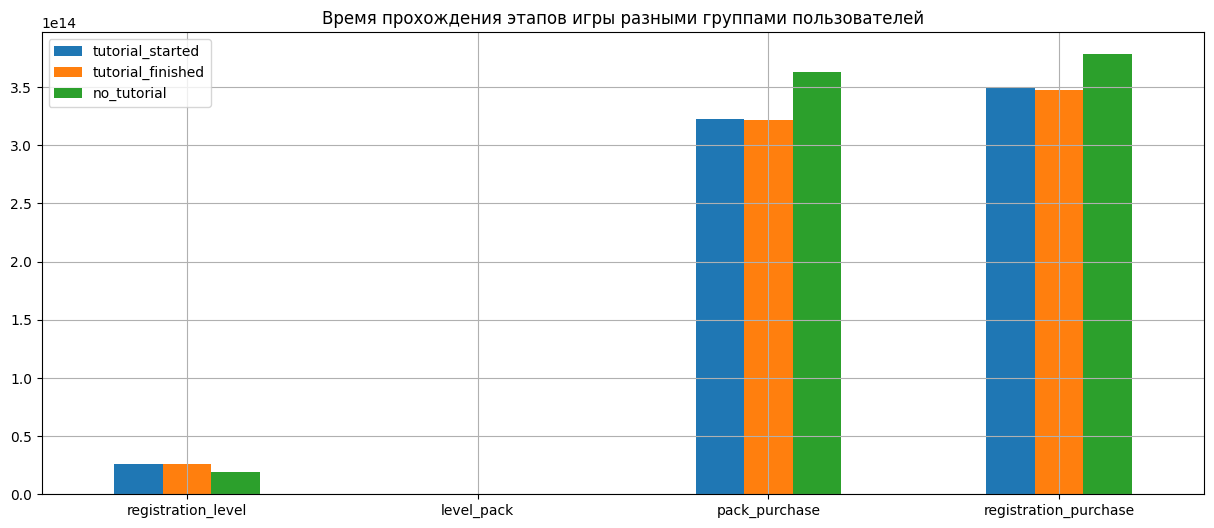

In [25]:
import matplotlib.pyplot as plt

visual = mean_results.plot(
     kind='bar',
    grid=True,
    figsize=(15, 6)
)

visual.set_title('Время прохождения этапов игры разными группами пользователей')
visual.xaxis.set_tick_params(rotation=0)

***Выводы:***
    *Обучение продливает среднее время от регистрации до выбора уровня сложности игры, так как само по себе занимает время. 
    Но тем временем оно незначительно сокращает время между выбором уровня сложности игры и выбором пакета вопросов 
    и на несколько часов сокращает время между выбором пакета вопросов и покупкой платного пакета вопросов.
    В среднем между регистрацией и покупкой у пользователей, ни разу не начинавших обучение, уходит на 8 часов больше времени, чем у остальных групп пользователей.
    Между группами пользователей, закончившими обучение хотябы раз и начавшими, но ни разу не завершавшими его, значительных отклонений не наблюдается.
    Среди пользователей, ни разу не начинавших обучение, большое количество зачернившихся сразу после регистрации. Видимо они изначально не имели большого интереса к игре и не прошли дальше регистрации.*

### 2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

#### a) Проследим влияние обучения на покупку

In [26]:
#Возвращаемся к датафрейду с пользователями, хотябы раз завершившими обучение
finished_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [27]:
#Создаем датафрейм для пользователей, ни разу не закончивших обучение
not_finished_df=total_events_df[~total_events_df['user_id'].isin(finished_tutorial_users)]
not_finished_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
5,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaN
6,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaN
21,80329.0,registration,NaN,2018-01-01 20:53:21,NaN,27840,NaN,NaN
27,80335.0,registration,NaN,2018-01-02 00:13:22,NaN,27844,NaN,NaN
...,...,...,...,...,...,...,...,...
66936,147244.0,registration,NaN,2018-12-31 12:03:59,NaN,47749,NaN,NaN
66938,147246.0,registration,NaN,2018-12-31 13:42:40,NaN,47750,NaN,NaN
66940,147248.0,registration,NaN,2018-12-31 18:49:30,NaN,47752,NaN,NaN
66942,147250.0,registration,NaN,2018-12-31 19:14:08,NaN,47754,NaN,NaN


In [28]:
#Считаем процент пользователей, оплативших покупку от общего числа пользователей:
#не начинавших обучение
not_started_users = no_tutorial_df['user_id'].nunique()
not_started_paid = no_tutorial_df[no_tutorial_df['event_type']=='purchase']['user_id'].nunique()
print('Процент юзеров, оплативших пакет вопросов от юзеров, не начинавших обучение: {:.2%}'.format(not_started_paid/not_started_users))

#не закончивших обучение (не важно, начинавших или нет)
not_finished_users = not_finished_df['user_id'].nunique()
not_finished_paid = not_finished_df[not_finished_df['event_type']=='purchase']['user_id'].nunique()
print('Процент юзеров, оплативших пакет вопросов от юзеров, не закончивших обучение(не важно, был ли старт обучения): {:.2%}'.format(not_finished_paid/not_finished_users))

#начавших, но не окончивших обучение
started_users = started_df['user_id'].nunique()
started_paid = started_df[started_df['event_type']=='purchase']['user_id'].nunique()
print('Процент юзеров, оплативших пакет вопросов от юзеров, начавших и не завершивших обучение: {:.2%}'.format(started_paid/started_users))

#начавших и окончивших обучение
finished_users = finished_df['user_id'].nunique()
finished_paid = finished_df[finished_df['event_type']=='purchase']['user_id'].nunique()
print('Процент юзеров, оплативших пакет вопросов от юзеров, начавших и завершивших обучение: {:.2%}'.format(finished_paid/finished_users))

Процент юзеров, оплативших пакет вопросов от юзеров, не начинавших обучение: 0.27%
Процент юзеров, оплативших пакет вопросов от юзеров, не закончивших обучение(не важно, был ли старт обучения): 1.58%
Процент юзеров, оплативших пакет вопросов от юзеров, начавших и не завершивших обучение: 13.31%
Процент юзеров, оплативших пакет вопросов от юзеров, начавших и завершивших обучение: 14.12%


#### b) Определим, есть ли разница, на каком этапе было успешное обучение.

In [29]:
#Создадим функции подсчета юзеров, начавших обучение, закончивших его и совершивших покупку, применим их к датафрейму, добавив соотв. столбцы
def started_cnt (row):
    if row.event_type == 'tutorial_start':
        return 1

def finished_cnt (row):
    if row.event_type == 'tutorial_finish':
        return 1
    
def purch_cnt (row):
    if row.event_type == 'purchase':
        return 1
    
total_events_df['tutorials_started'] = total_events_df.apply(started_cnt, axis=1)
total_events_df['tutorials_finished'] = total_events_df.apply(finished_cnt, axis=1)
total_events_df['purchased'] = total_events_df.apply(purch_cnt, axis=1)
total_events_df['start_time'] = str(total_events_df['start_time'])
total_events_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 68559 entries, 0 to 68558
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   event_id            66959 non-null  float64
 1   event_type          68559 non-null  object 
 2   selected_level      8342 non-null   object 
 3   start_time          68559 non-null  object 
 4   tutorial_id         32954 non-null  float64
 5   user_id             68559 non-null  int64  
 6   purchase_id         1600 non-null   float64
 7   amount              1600 non-null   float64
 8   tutorials_started   18050 non-null  float64
 9   tutorials_finished  14904 non-null  float64
 10  purchased           1600 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 6.3+ MB


In [30]:
grouped_started = total_events_df.drop(['event_id', 'tutorial_id', 'purchase_id'], axis=1).groupby(by='user_id').sum(numeric_only=True)
grouped_started

,amount,tutorials_started,tutorials_finished,purchased
user_id,,,,
27832,0.0,0.0,0.0,0.0
27833,0.0,1.0,1.0,0.0
27834,0.0,1.0,1.0,0.0
27835,0.0,1.0,1.0,0.0
27836,0.0,2.0,1.0,0.0
...,...,...,...,...
47753,0.0,1.0,1.0,0.0
47754,0.0,0.0,0.0,0.0
47755,0.0,1.0,1.0,0.0


In [31]:
#Подсчитаем пользователей и юзеров
def if_user(row):
    if row.tutorials_finished > 0.0:
        return 1
    
def if_client(row):
    if row.purchased > 0.0:
        return 1    
    
grouped_started['user'] = grouped_started.apply(if_user, axis=1)
grouped_started['client'] = grouped_started.apply(if_client, axis=1)
grouped_started

,amount,tutorials_started,tutorials_finished,purchased,user,client
user_id,,,,,,
27832,0.0,0.0,0.0,0.0,NaN,NaN
27833,0.0,1.0,1.0,0.0,1.0,NaN
27834,0.0,1.0,1.0,0.0,1.0,NaN
27835,0.0,1.0,1.0,0.0,1.0,NaN
27836,0.0,2.0,1.0,0.0,1.0,NaN
...,...,...,...,...,...,...
47753,0.0,1.0,1.0,0.0,1.0,NaN
47754,0.0,0.0,0.0,0.0,NaN,NaN
47755,0.0,1.0,1.0,0.0,1.0,NaN


In [32]:
#Сгруппируем данные по количеству начал обучения и рассчитаем конверсию для каждой группы
grouped_started_count = grouped_started.groupby(by='tutorials_started').sum(numeric_only=True)
grouped_started_count['conversion'] = (grouped_started_count['client']*100/grouped_started_count['user']).round(2)
grouped_started_count

,amount,tutorials_finished,purchased,user,client,conversion
tutorials_started,,,,,,
0.0,2825.0,0.0,22.0,0.0,22.0,inf
1.0,132475.0,7548.0,1207.0,7548.0,1207.0,15.99
2.0,24950.0,2655.0,218.0,1538.0,218.0,14.17
3.0,5675.0,1031.0,51.0,425.0,51.0,12.00
4.0,2950.0,719.0,30.0,221.0,30.0,13.57
5.0,1950.0,428.0,16.0,109.0,16.0,14.68
6.0,1675.0,557.0,14.0,116.0,14.0,12.07
7.0,1325.0,558.0,12.0,94.0,12.0,12.77
8.0,1350.0,572.0,13.0,86.0,13.0,15.12


In [33]:
#Сгруппируем данные по количеству окончаний обучения и рассчитаем конверсию для каждой группы
grouped_finished_count = grouped_started.groupby(by='tutorials_finished').sum(numeric_only=True)
grouped_finished_count['conversion'] = (grouped_finished_count['client']*100/grouped_finished_count['user']).round(2)
grouped_finished_count

,amount,tutorials_started,purchased,user,client,conversion
tutorials_finished,,,,,,
0.0,16575.0,1663.0,153.0,0.0,153.0,inf
1.0,126025.0,8537.0,1143.0,8015.0,1143.0,14.26
2.0,20625.0,2891.0,182.0,1321.0,182.0,13.78
3.0,5475.0,1217.0,44.0,345.0,44.0,12.75
4.0,1950.0,842.0,19.0,178.0,19.0,10.67
5.0,1950.0,732.0,19.0,117.0,19.0,16.24
6.0,1625.0,725.0,15.0,101.0,15.0,14.85
7.0,1750.0,775.0,15.0,97.0,15.0,15.46
8.0,800.0,470.0,6.0,54.0,6.0,11.11


#### c) Визуализируем результаты

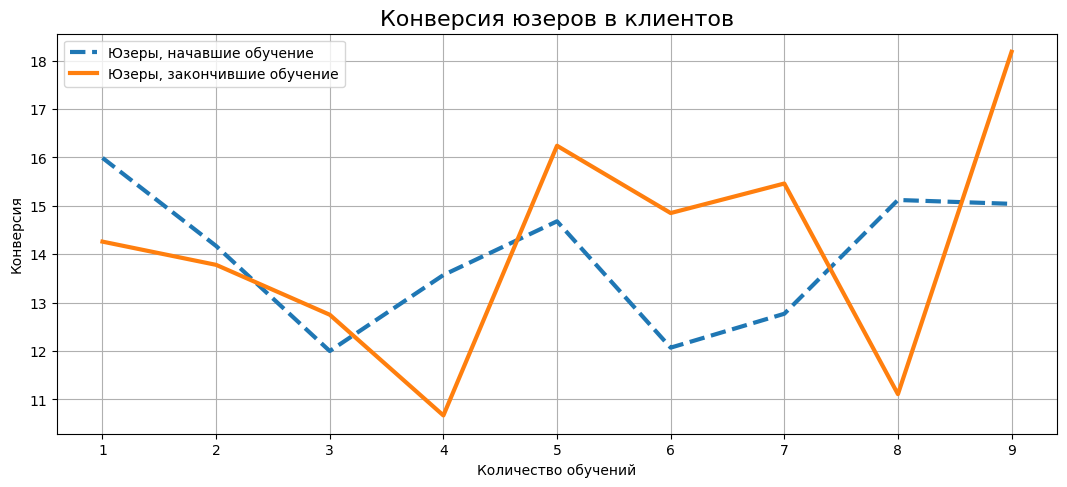

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(grouped_started_count['conversion'], label='Юзеры, начавшие обучение', lw=3,linestyle='dashed')
axes.plot(grouped_finished_count['conversion'], label='Юзеры, закончившие обучение', lw=3)

#Установка параметров отображения
axes.set_title('Конверсия юзеров в клиентов', fontsize=16)
axes.set_xlabel('Количество обучений')
axes.set_ylabel('Конверсия')
axes.grid()
axes.legend();

***Выводы:***
*Судя по результатам исследования, пользователи, прошедшие обучение, с большей вероятностью конвертируются в клиентов, чем пользователи, не проходившие обучение совсем. При этом разница не значительная, было ли обучение окончено, или нет. Возможно пользователи, начав обучение, проходят все его этапы, но не подтверждают окончание обучения и сворачивают экран, не совершив целевое действие, означающее окончание обучения.
Что касается этапа, на котором юзер проходит обучение - вне зависимости от того, в какой момент и какой раз по счету юзер проходит обучение - конверсия в покупку всегда выше, чем у сегмента пользователей, ни разу не начинавших обучение.*

### 3. Проверить, насколько прозрачен процесс взаимодействия с игрой.

In [35]:
#Проверим, как часто юзеры возвращаются к обучению после того, как выбрали уровень сложности
tutorial_after_level_df = registration_df.merge(tutorial_df,on=['user_id'], how='right')
tutorial_after_level_df = tutorial_after_level_df.drop(
    columns=['event_id_x','selected_level_x','purchase_id_x','amount_x','event_id_y','purchase_id_y','amount_y']
    )
tutorial_after_level_df = tutorial_after_level_df.merge(level_df,on=['user_id'], how='left')
tutorial_after_level_df = tutorial_after_level_df.drop(
    columns=['tutorial_id_x','selected_level_y','tutorial_id_y','event_id','selected_level','tutorial_id','purchase_id','amount']
    )
tutorial_after_level_df

,event_type_x,registration_time,user_id,event_type_y,tutorial_start_time,event_type,level_time
0,registration,2018-01-01 13:28:07,27836,tutorial_start,2018-01-01 14:54:40,NaN,NaT
1,registration,2018-01-01 11:54:47,27835,tutorial_start,2018-01-01 15:00:51,level_choice,2018-01-01 20:37:22
2,registration,2018-01-01 13:28:07,27836,tutorial_start,2018-01-01 15:40:43,NaN,NaT
3,registration,2018-01-01 04:07:25,27833,tutorial_start,2018-01-01 17:47:40,NaN,NaT
4,registration,2018-01-01 18:24:01,27839,tutorial_start,2018-01-01 19:11:36,level_choice,2018-01-01 22:37:50
...,...,...,...,...,...,...,...
18045,registration,2018-12-31 03:01:17,47747,tutorial_start,2018-12-31 10:21:11,level_choice,2018-12-31 12:24:40
18046,registration,2018-12-31 13:55:01,47751,tutorial_start,2018-12-31 19:38:14,NaN,NaT
18047,registration,2018-12-31 18:58:55,47753,tutorial_start,2018-12-31 20:54:56,level_choice,2018-12-31 22:36:19
18048,registration,2018-12-31 21:15:14,47755,tutorial_start,2019-01-01 00:08:14,level_choice,2019-01-01 05:04:52


In [36]:
#Вычисляем время между стартом обучения и выбором уровня
tutorial_after_level_df['tutorial_level_delta']=tutorial_after_level_df['level_time']-tutorial_after_level_df['tutorial_start_time']
tutorial_after_level_df['tutorial_level_delta']=tutorial_after_level_df['tutorial_level_delta'].fillna(pd.Timedelta(0))
tutorial_after_level_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18050 entries, 0 to 18049
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   event_type_x          18050 non-null  object         
 1   registration_time     18050 non-null  datetime64[ns] 
 2   user_id               18050 non-null  int64          
 3   event_type_y          18050 non-null  object         
 4   tutorial_start_time   18050 non-null  datetime64[ns] 
 5   event_type            12686 non-null  object         
 6   level_time            12686 non-null  datetime64[ns] 
 7   tutorial_level_delta  18050 non-null  timedelta64[ns]
dtypes: datetime64[ns](3), int64(1), object(3), timedelta64[ns](1)
memory usage: 1.1+ MB


In [37]:
#Cоздаем функцию для подсчета количества юзеров, проходивших обучение поле выбора уровня cложности
def add_tutorial_cnt (row):
    if row['tutorial_level_delta']< pd.Timedelta(0):
        return 1
    
tutorial_after_level_df['add_tutorial'] = tutorial_after_level_df.apply(add_tutorial_cnt,axis=1)
tutorial_after_level_df

,event_type_x,registration_time,user_id,event_type_y,tutorial_start_time,event_type,level_time,tutorial_level_delta,add_tutorial
0,registration,2018-01-01 13:28:07,27836,tutorial_start,2018-01-01 14:54:40,NaN,NaT,0 days 00:00:00,NaN
1,registration,2018-01-01 11:54:47,27835,tutorial_start,2018-01-01 15:00:51,level_choice,2018-01-01 20:37:22,0 days 05:36:31,NaN
2,registration,2018-01-01 13:28:07,27836,tutorial_start,2018-01-01 15:40:43,NaN,NaT,0 days 00:00:00,NaN
3,registration,2018-01-01 04:07:25,27833,tutorial_start,2018-01-01 17:47:40,NaN,NaT,0 days 00:00:00,NaN
4,registration,2018-01-01 18:24:01,27839,tutorial_start,2018-01-01 19:11:36,level_choice,2018-01-01 22:37:50,0 days 03:26:14,NaN
...,...,...,...,...,...,...,...,...,...
18045,registration,2018-12-31 03:01:17,47747,tutorial_start,2018-12-31 10:21:11,level_choice,2018-12-31 12:24:40,0 days 02:03:29,NaN
18046,registration,2018-12-31 13:55:01,47751,tutorial_start,2018-12-31 19:38:14,NaN,NaT,0 days 00:00:00,NaN
18047,registration,2018-12-31 18:58:55,47753,tutorial_start,2018-12-31 20:54:56,level_choice,2018-12-31 22:36:19,0 days 01:41:23,NaN
18048,registration,2018-12-31 21:15:14,47755,tutorial_start,2019-01-01 00:08:14,level_choice,2019-01-01 05:04:52,0 days 04:56:38,NaN


In [38]:
add_tutorial_df = tutorial_after_level_df[tutorial_after_level_df['add_tutorial']>0]
print('Количество пользователей, начинавших обучение после выбора уровня сложности:', add_tutorial_df['user_id'].nunique())
percent = (add_tutorial_df['user_id'].nunique()*100/total_events_df['user_id'].nunique())
print('Процент пользователей, начинавших обучение после выбора уровня сложности, от всех зарегистрированных пользователей:', round(percent, 2))
level_choosed_users = total_events_df[total_events_df['event_type']=='level_choice']
percent2=(add_tutorial_df['user_id'].nunique()*100/level_choosed_users['user_id'].nunique())
print('Процент пользователей, начинавших обучение после выбора уровня сложности, от всех пользователей, выбиравших уровень сложности:', round(percent2, 2))

Количество пользователей, начинавших обучение после выбора уровня сложности: 1386
Процент пользователей, начинавших обучение после выбора уровня сложности, от всех зарегистрированных пользователей: 6.96
Процент пользователей, начинавших обучение после выбора уровня сложности, от всех пользователей, выбиравших уровень сложности: 16.61


***Выводы:***
*Доля пользователей, вернувшихся к обучению после выбора уровня сложности, небольшая. Это говорит о том, что игра достаточно понятная и вызывает затруднения лишь у небольшой части пользователей. Возможно это пользователи, которые вернулись к игре через какое-то время и им понадобилось повторное обучение.*